In [93]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
from data_classes import MovieData, BookData
from do_mf_lenskit import *
pd.set_option('display.max_columns', None)

## This notebook reads in the outputs already created from the LLM and analyzes the output

In [209]:
item_type = 'movie'

In [210]:
from output_calcs import *
pd.set_option('display.max_colwidth', None)
size_of_sample = 845
output_path = f'output_data/{item_type}'
llm_recs = LLMRecs(output_path, item_type, size_of_sample)
df = llm_recs.build_full_df()
# # Load CF model
with open(f'output_data/{item_type}/probes/als_explicit.pkl','rb') as f:
    model, u2i, i2i, i2u, i2v = pickle.load(f)
if item_type == 'movie':
    data = MovieData()
else:
    data = BookData()

/Users/jessicakahn/Documents/repos/steering/data_classes.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df_pos['rating_count'] = rating_df_pos.groupby('user_id')['item_id'].transform('count')
/Users/jessicakahn/Documents/repos/steering/output_calcs.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.map_dicts = rec_data.get_map_dicts()
/Users/jessicakahn/Documents/repos/steering/data_classes.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [208]:
# item_type = 'movie'
# df = pd.read_csv(f'output_data/{item_type}/result_df.csv') #This is created further down this notebook
'output_data/movie/output_dict_movie_845_withnegs.pt' == 'output_data/book/output_dict_book_845_withnegs.pt'

False

In [211]:
with open('output_data/movie/can_dict_new.json', 'r') as json_file:
    test_cans = json.load(json_file)

In [212]:
len(test_cans)

845

In [213]:
# Examine genre by user gender
d = 'movie_id | movie title | release date | video release date | IMDb URL | unknown | Action | Adventure | Animation | Children | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western'
genre_cols = 'movie_id | unknown | Action | Adventure | Animation | Children | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western'.split(' | ')
genre_only_cols = 'unknown | Action | Adventure | Animation | Children | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western'.split(' | ')
column_names = d.split(' | ')
data_path = '/Users/jessicakahn/Documents/repos/Glocal_K/1'
item = pd.read_csv(os.path.join(data_path,'ml-100k/u.item'), sep='|',header=None,names=column_names,encoding='latin-1')
item_df = item[genre_cols]

### Calculate genre changes from baseline -> steered

In [214]:
# import ast
# df['baseline_ids'] =df['baseline_ids'].apply(ast.literal_eval)
# df['steered_ids'] = df['steered_ids'].apply(ast.literal_eval)
df_empty = pd.DataFrame(columns=['user_id','user_gender','row_num','movie_id', 'genre','count'])
# bdf_long = pd.melt(bdf, id_vars=['user_gender','row_num'], value_vars=[genre_only_cols],
#                   var_name='Genre', value_name='Value')
for steer_type in ('baseline', 'steered'):
    bdf = df[[f'{steer_type}_ids','user_id','user_gender']].explode(f'{steer_type}_ids')
    # Explode isn't working in the line above print(bdf.head(2))
    bdf['row_num'] = bdf.groupby(['user_id','user_gender'], sort=False).cumcount() + 1
    bdf = bdf.merge(item_df, how='left', left_on=f'{steer_type}_ids', right_on='movie_id')
    bdf['steer_type'] = f'{steer_type}'

    bdf.head()
    bdf_long = pd.melt(bdf, 
            id_vars=['user_id','user_gender','row_num','movie_id','steer_type'], 
            value_vars=genre_only_cols, 
            var_name='genre', 
            value_name='count')

    bdf_long = bdf_long[bdf_long['count'] > 0]
    df_empty = pd.concat([df_empty, bdf_long], axis=0)



/var/folders/z4/ynvj_8y53mb4nn7qbl3fk1_40000gp/T/ipykernel_17365/694108015.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_empty = pd.concat([df_empty, bdf_long], axis=0)


In [172]:
# genre_only_cols

In [222]:
rating_df = df_empty

In [220]:
# Append user scores for each movie
header = ['user_id', 'movie_id', 'rating', 'timestamp']
orig_rating_df = pd.read_csv('/Users/jessicakahn/Documents/repos/Glocal_K/1/ml-100k/u.data', sep='\t', names=header)

In [221]:
orig_rating_df.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [224]:
rating_df = pd.merge(rating_df, orig_rating_df[['user_id','movie_id','rating']], 
                     on=['user_id','movie_id']
)

In [225]:
rating_df.head()

,user_id,user_gender,row_num,movie_id,genre,count,steer_type,rating
0,742,M,1,222.0,Action,1.0,baseline,2
1,742,M,9,117.0,Action,1.0,baseline,2
2,884,M,8,323.0,Action,1.0,baseline,2
3,884,M,10,515.0,Action,1.0,baseline,4
4,836,M,8,260.0,Action,1.0,baseline,2


In [132]:
from scipy import stats

In [226]:
df_empty['user_movie'] = df_empty['user_id'].astype(str) + '_' + df_empty['movie_id'].astype(str)
df_empty.head()

,user_id,user_gender,row_num,movie_id,genre,count,steer_type,user_movie
8025,742,M,1,222.0,Action,1.0,baseline,742_222.0
8027,742,M,3,273.0,Action,1.0,baseline,742_273.0
8033,742,M,9,117.0,Action,1.0,baseline,742_117.0
8042,884,M,8,323.0,Action,1.0,baseline,884_323.0
8044,884,M,10,515.0,Action,1.0,baseline,884_515.0


In [227]:
user_movie_intersect = (
    set(df_empty[(df_empty.steer_type=='baseline') & (df_empty.user_gender=='F') & (df_empty.genre=='Romance')]['user_movie']) 
    & set(df_empty[(df_empty.steer_type=='steered') & (df_empty.user_gender=='F') & (df_empty.genre=='Romance')]['user_movie'])
)
len(user_movie_intersect)
            

519

In [228]:
# Arrays are different shapes - probably from parsing.
# Might need to change function to filter on only ids in the candidate set
steered_array = df_empty[(df_empty.user_movie.isin(user_movie_intersect)) & (df_empty.steer_type=='steered')]
baseline_array = df_empty[(df_empty.user_movie.isin(user_movie_intersect)) & (df_empty.steer_type=='baseline')]

print(baseline_array.shape, steered_array.shape)

(1397, 8) (1397, 8)


In [136]:
# df.head()
# orig_rating_df.head()
orig_rating_dict = (
    orig_rating_df.groupby("user_id")
      .apply(lambda g: dict(zip(g["item_id"], g["rating"])))
      .to_dict()
)

/var/folders/z4/ynvj_8y53mb4nn7qbl3fk1_40000gp/T/ipykernel_17365/1722814337.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: dict(zip(g["item_id"], g["rating"])))


In [137]:
# orig_rating_df[orig_rating_df.user_id==196]
# orig_rating_dict[196]
list(df[df.user_id==196]['baseline_ids'])[0]


[173, 257, 381, 286, 258, 367, 382, 1118, 451, 8]

In [229]:
# From https://coralogix.com/ai-blog/a-practical-guide-to-normalized-discounted-cumulative-gain-ndcg/
# This is per user - how is this reported for all users? As an average? 
def dcg_at_k(r, k):
    r = np.asarray(r)[:k]
    if r.size:
        return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
    return 0.

def ndcg_at_k(r, k):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k) / dcg_max

actual = orig_rating_dict[196]

baseline = list(df[df.user_id==196]['baseline_ids'])[0]
steered = list(df[df.user_id==196]['steered_ids'])[0]

# Convert recommendation list to relevance scores
b = [actual.get(i) for i in baseline if actual.get(i) is not None]
s = [actual.get(i) for i in steered if actual.get(i) is not None]

print('For a single user with user_id 196: ')
print("NDCG@10: ", 'baseline: ', ndcg_at_k(b, 10), 'steered: ', ndcg_at_k(s, 10) )

For a single user with user_id 196: 
NDCG@10:  baseline:  0.793731087349329 steered:  0.8462151806210928


In [230]:
gender_dict = data.get_gender_dict()

In [142]:
# # gender_dict[196]
# for i, row in df.iterrows():
#     print(row['user_id'], len(row['steered_ids']), row['steered_ids'], len(row['steered_ids']))

### Calculate NDCG for baseline vs steered by gender

In [482]:
baseline_ndcg_f = []
baseline_ndcg_m = []
steered_ndcg_f = []
steered_ndcg_m = []
for user in df['user_id'].unique():
    actual = orig_rating_dict[user]

    baseline = list(df[df.user_id==user]['baseline_ids'])[0]
    steered = list(df[df.user_id==user]['steered_ids'])[0]

    # Convert recommendation list to relevance scores
    b = [actual.get(i) for i in baseline if actual.get(i) is not None]
    s = [actual.get(i) for i in steered if actual.get(i) is not None]
    if gender_dict[user] == 'M':
        baseline_ndcg_m.append(ndcg_at_k(b, 10))
        steered_ndcg_m.append(ndcg_at_k(s, 10))
    elif gender_dict[user] == 'F':
        baseline_ndcg_f.append(ndcg_at_k(b, 10))
        steered_ndcg_f.append(ndcg_at_k(s, 10))



print('Baseline NDCG Gender=F: ', np.mean(baseline_ndcg_f), '\n',
      'Baseline NDCG Gender=M: ', np.mean(baseline_ndcg_m), '\n',
      'Steered NDCG Gender=F: ',np.mean(steered_ndcg_f), '\n',
      'Steered NDCG Gender=M: ', np.mean(steered_ndcg_m)), '\n',

Baseline NDCG Gender=F:  0.9215826473462527 
 Baseline NDCG Gender=M:  0.9297249871457153 
 Steered NDCG Gender=F:  0.923040709004922 
 Steered NDCG Gender=M:  0.9288002557365913


(None, '\n')

In [484]:
# baseline_ndcg
print('Difference in male NDCG after steering')
np.mean(steered_ndcg_m)-np.mean(baseline_ndcg_m)

Difference in male NDCG after steering


np.float64(-0.0009247314091239689)

In [485]:
print('Difference in female NDCG after steering')
np.mean(steered_ndcg_f)-np.mean(baseline_ndcg_f)

Difference in female NDCG after steering


np.float64(0.0014580616586692408)

In [234]:
df_empty.head()

,user_id,user_gender,row_num,movie_id,genre,count,steer_type,user_movie
8025,742,M,1,222.0,Action,1.0,baseline,742_222.0
8027,742,M,3,273.0,Action,1.0,baseline,742_273.0
8033,742,M,9,117.0,Action,1.0,baseline,742_117.0
8042,884,M,8,323.0,Action,1.0,baseline,884_323.0
8044,884,M,10,515.0,Action,1.0,baseline,884_515.0


In [235]:
len(set(df_empty[df_empty.steer_type=='baseline']['user_movie']) - set(df_empty[df_empty.steer_type=='steered']['user_movie']))

175

In [236]:
df_empty['user_movie']=df_empty['user_id'].astype(str)+"_"+df_empty['movie_id'].astype(str)

### Statistical tests on the distributions

In [237]:
from scipy.stats import wilcoxon

In [293]:
# Overall wilcoxon test on ranking is significant
before = df_empty[(df_empty.steer_type=='baseline') ]
after = df_empty[(df_empty.steer_type=='steered') ]
before_after = pd.merge(before, after, on='user_movie', how='inner')
before_after['row_num_x'] = pd.to_numeric(before_after['row_num_x'], errors='coerce')
before_after['row_num_y'] = pd.to_numeric(before_after['row_num_y'], errors='coerce')
stat, p_value = wilcoxon(before_after['row_num_x'], before_after['row_num_y'])
print(stat, p_value)

263285677.5 0.006065005937278964


In [292]:
# Wilcoxon test on ranking by gender 
for user_gender in ('F','M'):
    before = df_empty[(df_empty.user_gender==user_gender) & (df_empty.steer_type=='baseline') ]
    after = df_empty[(df_empty.user_gender==user_gender) & (df_empty.steer_type=='steered') ]
    # print(before.shape, after.shape)
    before_after = pd.merge(before, after, on='user_movie', how='inner')
    before_after['row_num_x'] = pd.to_numeric(before_after['row_num_x'], errors='coerce')
    before_after['row_num_y'] = pd.to_numeric(before_after['row_num_y'], errors='coerce')
    # print(before_after.shape)
    stat, p_value = wilcoxon(before_after['row_num_x'], before_after['row_num_y'])
    print(user_gender, stat, p_value)

F 17817200.0 5.837439174873134e-07
M 144127989.0 0.8755673825560322


In [286]:
# before_after['row_num_x']
# before_after.shape
# before_after.head()
# df_empty.shape

In [289]:
for genre in genre_only_cols:
    for user_gender in ('F','M'):
        before = df_empty[(df_empty.user_gender==user_gender) & (df_empty.genre==genre) & (df_empty.steer_type=='baseline') ]
        after = df_empty[(df_empty.user_gender==user_gender) & (df_empty.genre==genre) & (df_empty.steer_type=='steered') ]
        before_after = pd.merge(before, after, on='user_movie', how='inner')
        before_after['row_num_x'] = pd.to_numeric(before_after['row_num_x'], errors='coerce')
        before_after['row_num_y'] = pd.to_numeric(before_after['row_num_y'], errors='coerce')
        stat, p_value = wilcoxon(before_after['row_num_x'], before_after['row_num_y'])
        if p_value < 0.1:
            print(before.shape, after.shape)
            print(f'Wilcoxon test for genre: {genre} and user gender {user_gender}: ', stat, p_value)



/Users/jessicakahn/Documents/repos/steering/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1006: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return fun(*args, **kwargs)
/Users/jessicakahn/Documents/repos/steering/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1006: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return fun(*args, **kwargs)


(114, 8) (114, 8)
Wilcoxon test for genre: Musical and user gender F:  998.0 0.05014617425086632
(213, 8) (213, 8)
Wilcoxon test for genre: Musical and user gender M:  4629.0 0.0492576870874833
(243, 8) (252, 8)
Wilcoxon test for genre: Sci-Fi and user gender F:  6253.0 0.06701658933648866


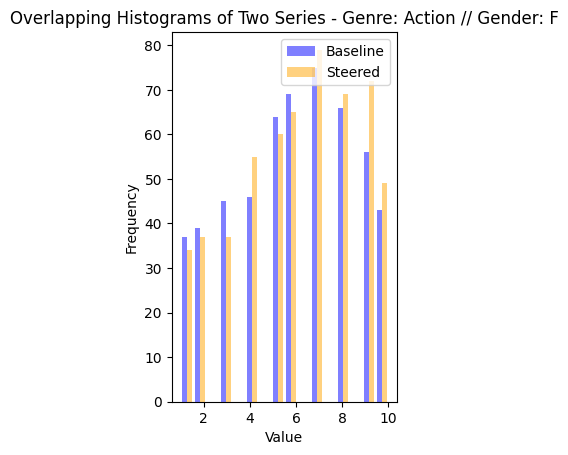

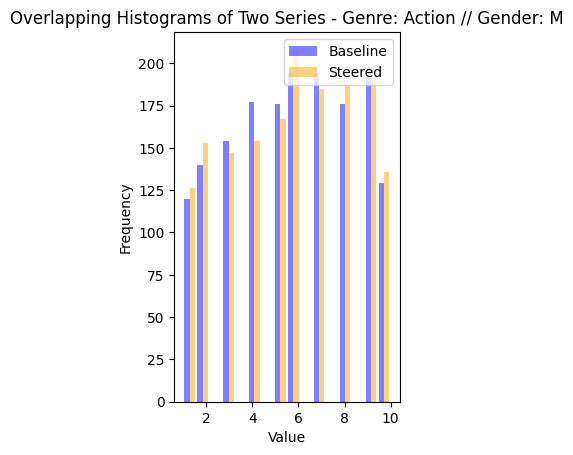

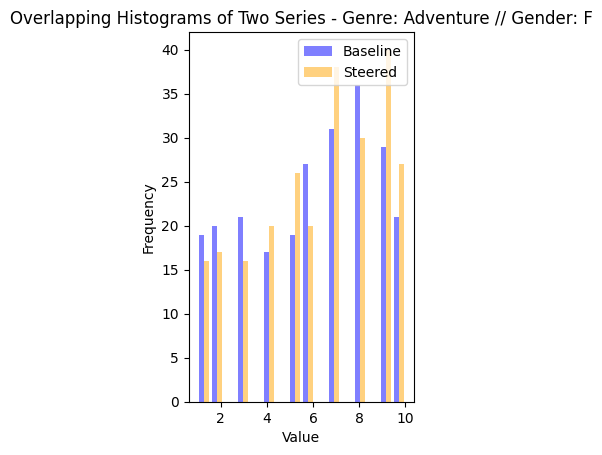

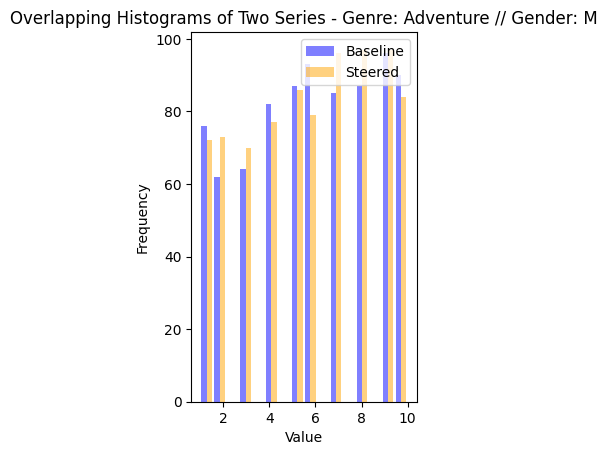

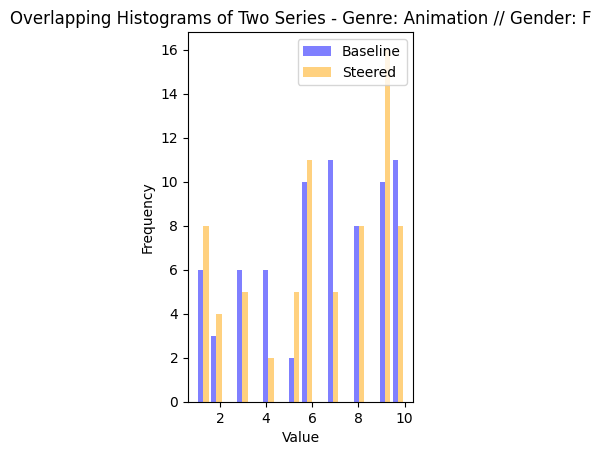

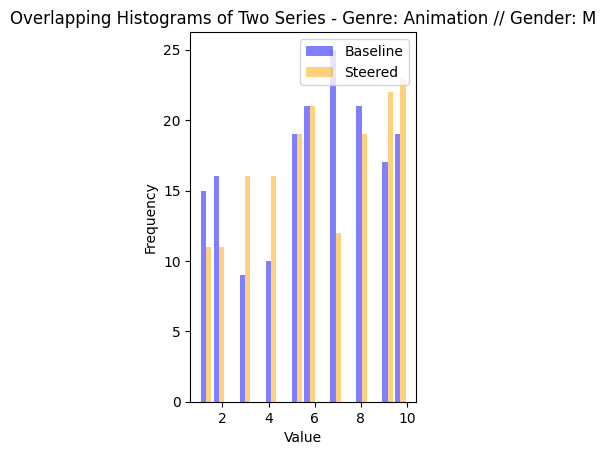

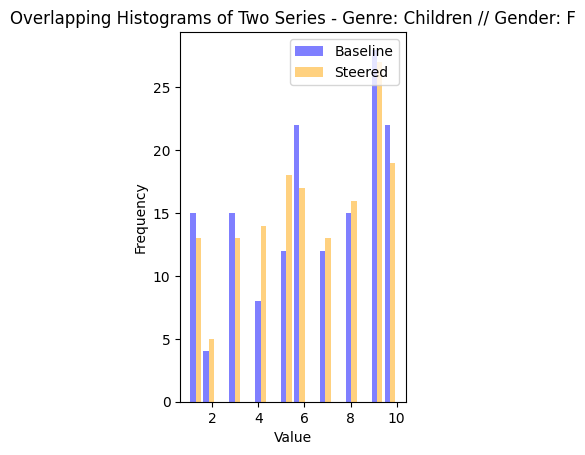

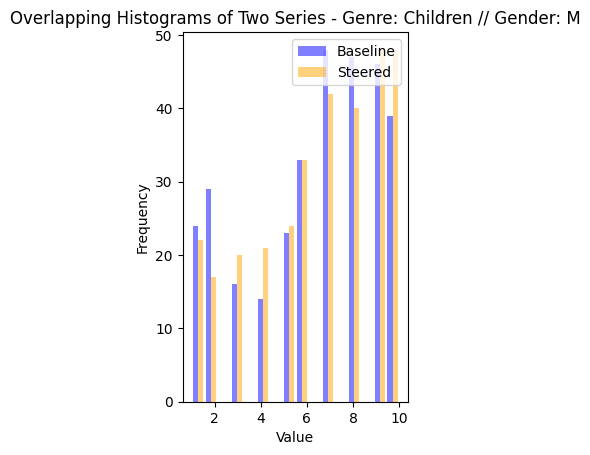

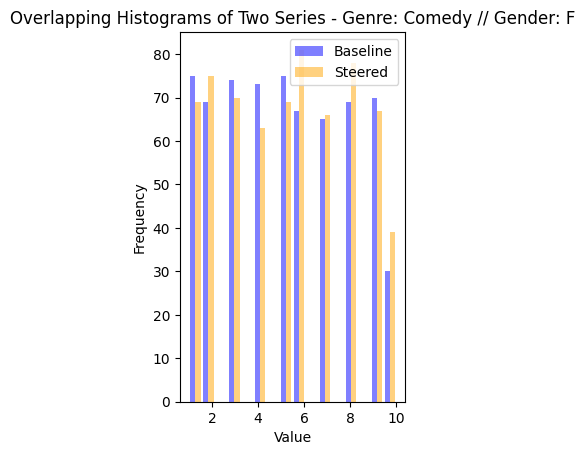

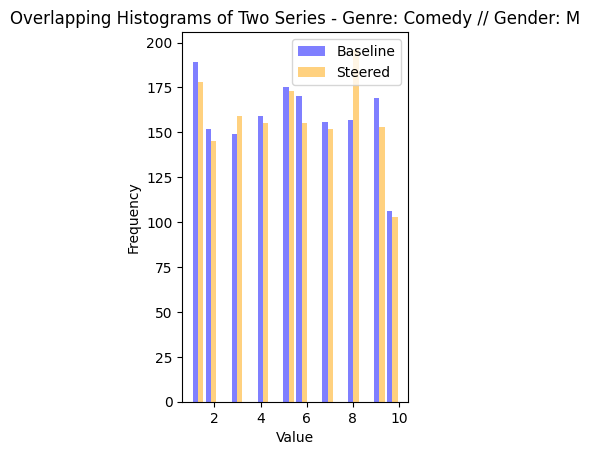

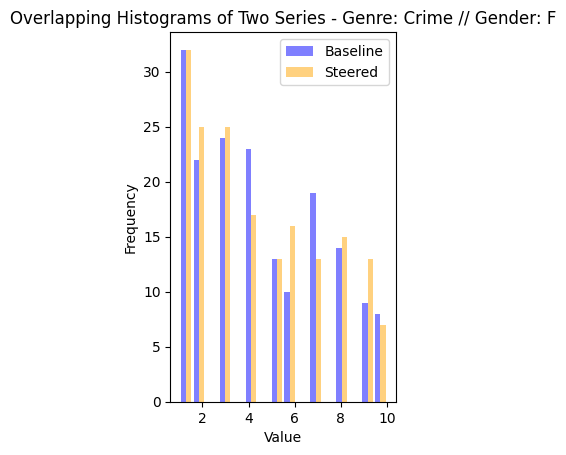

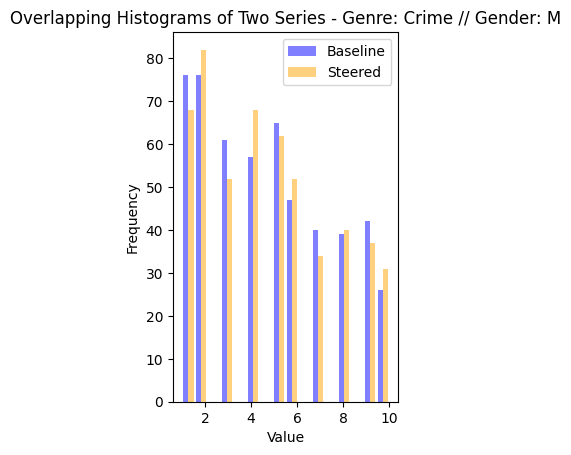

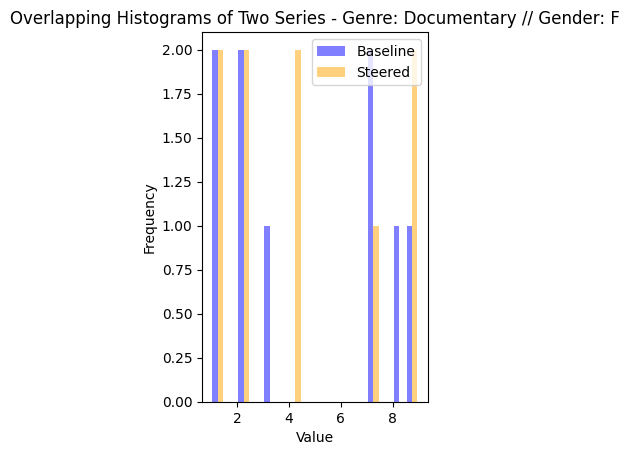

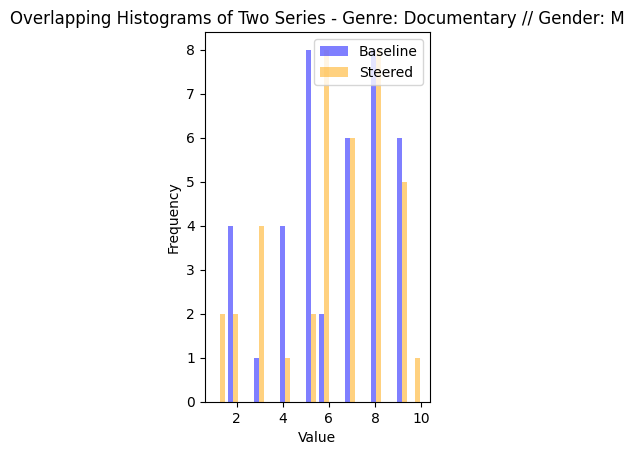

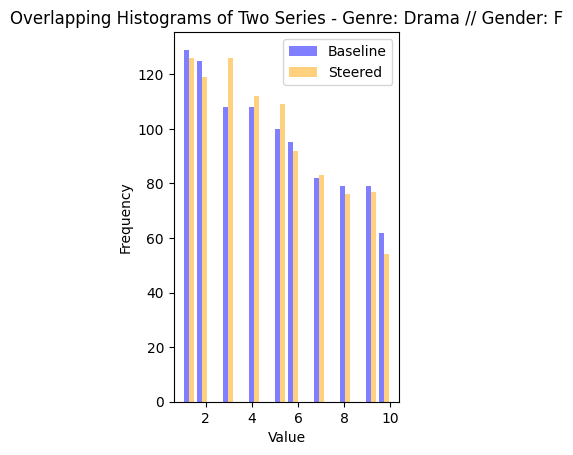

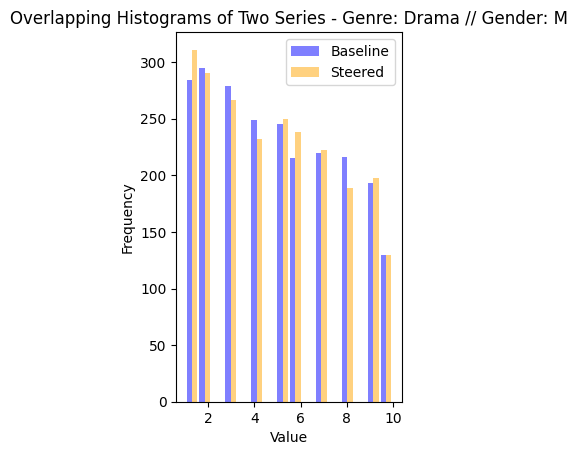

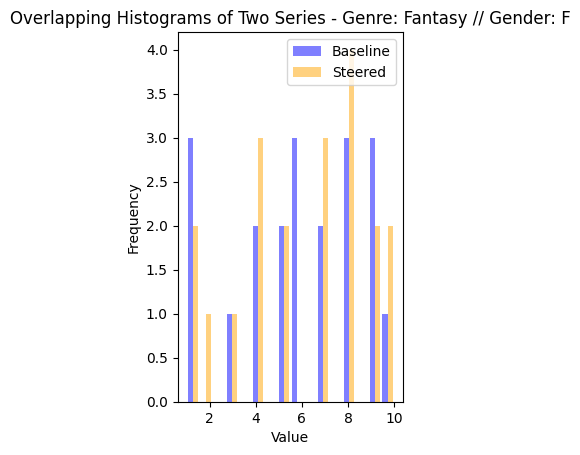

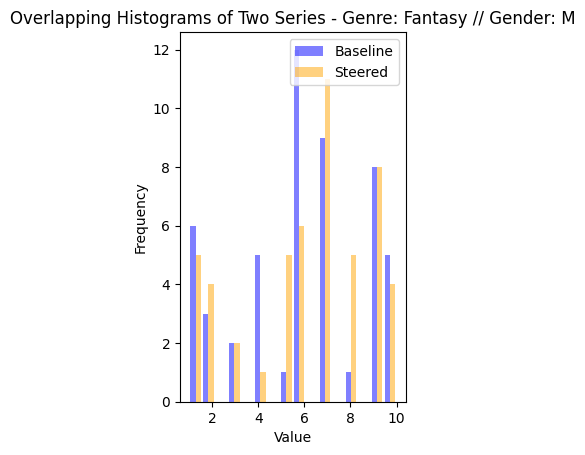

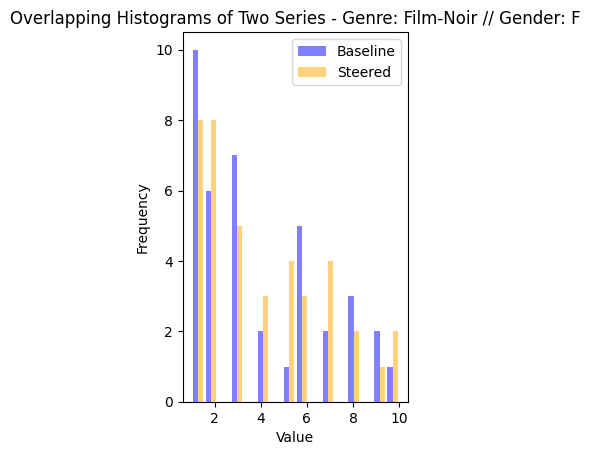

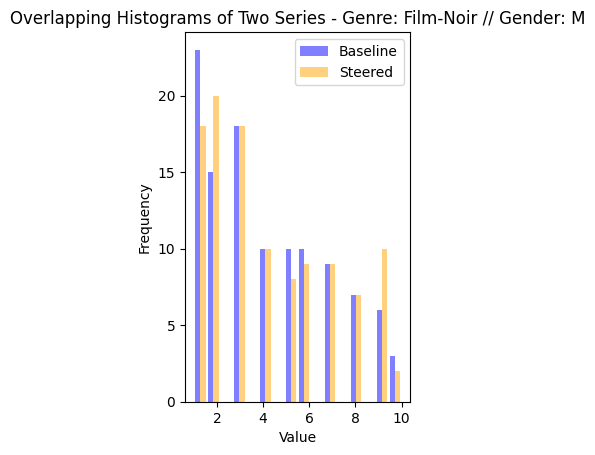

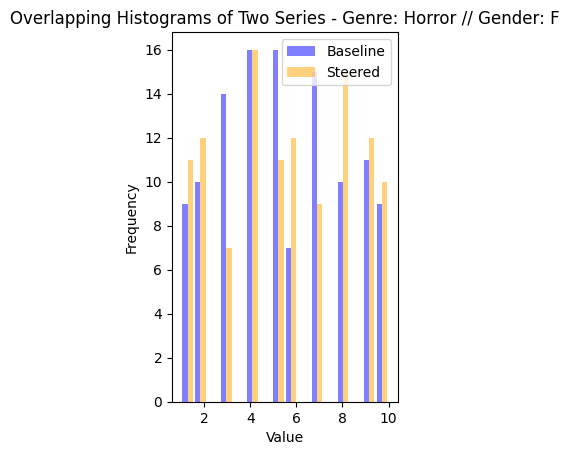

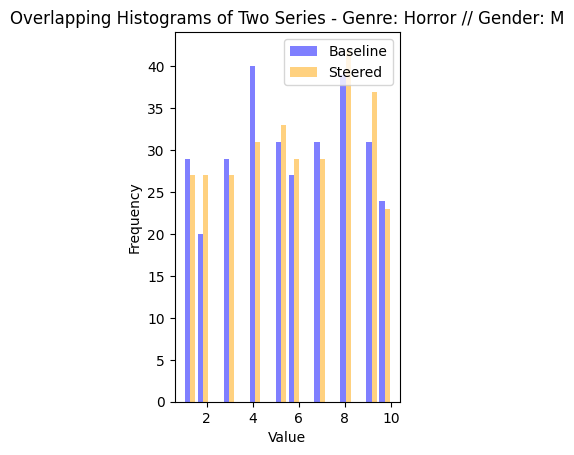

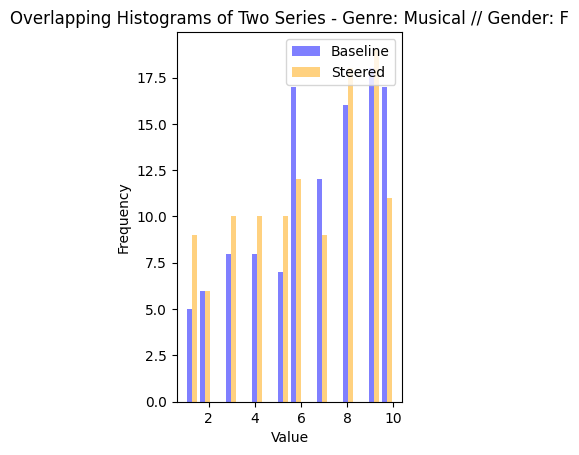

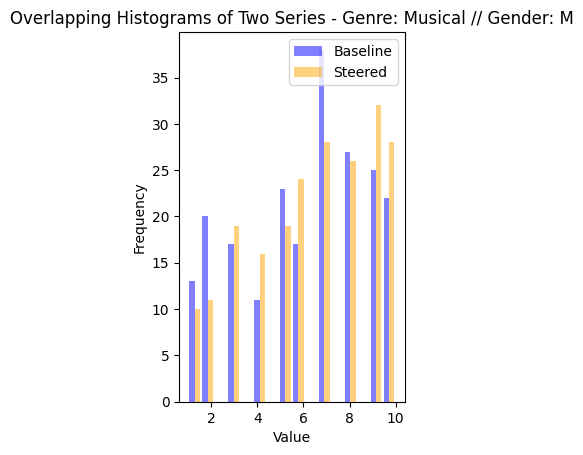

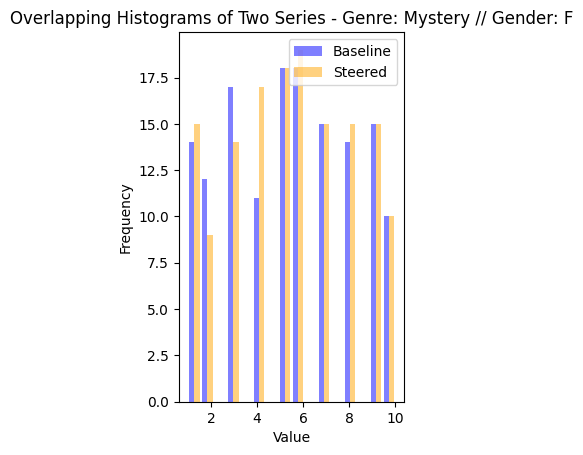

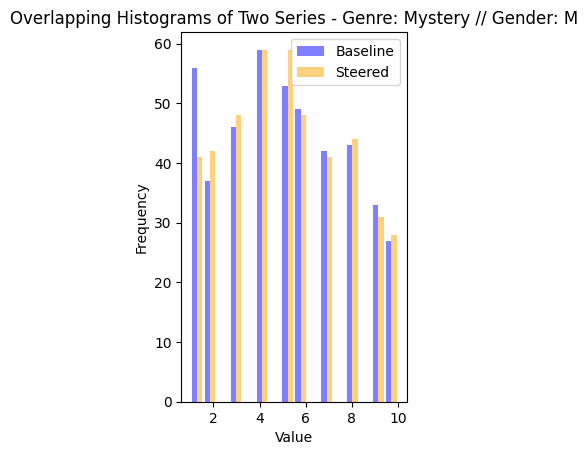

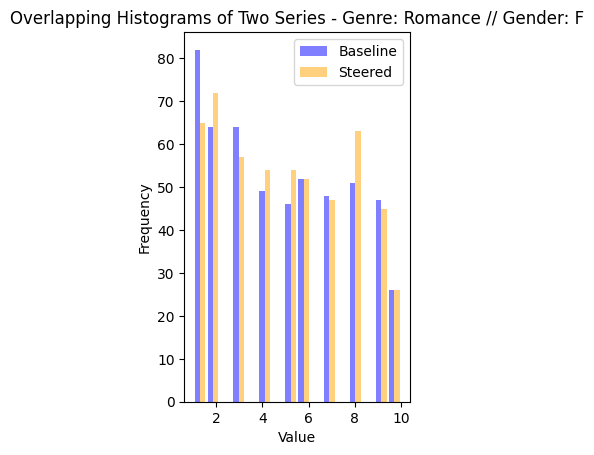

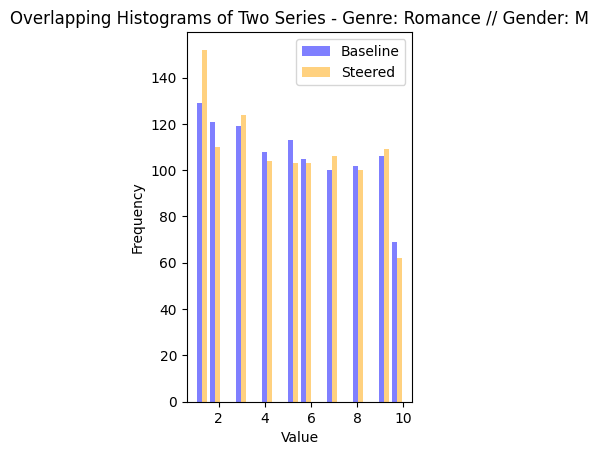

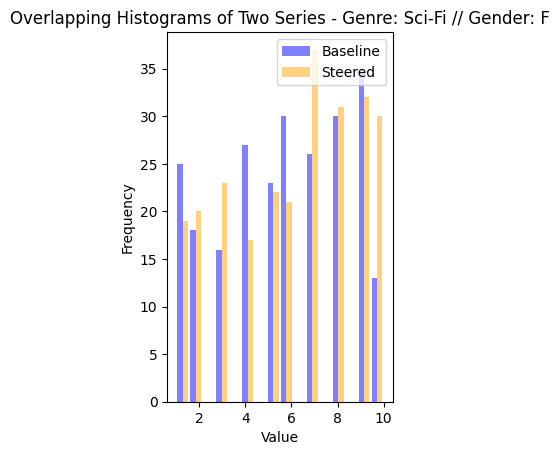

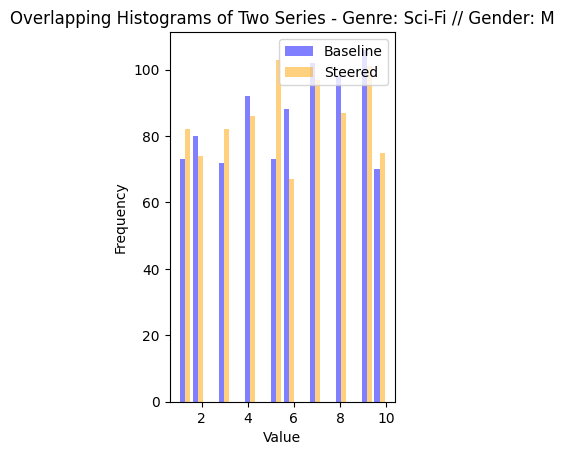

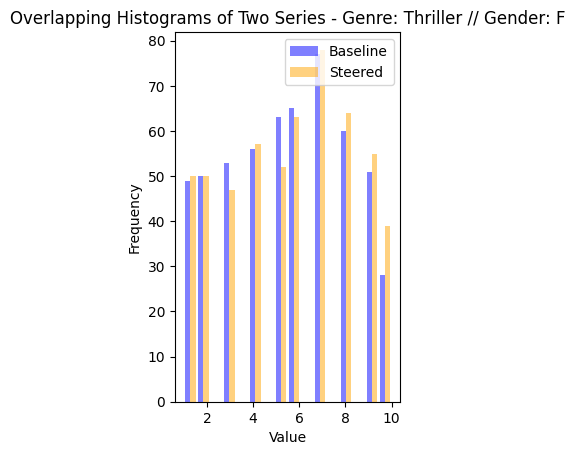

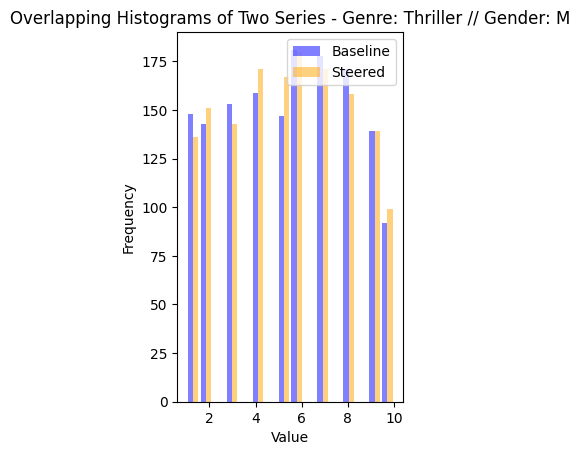

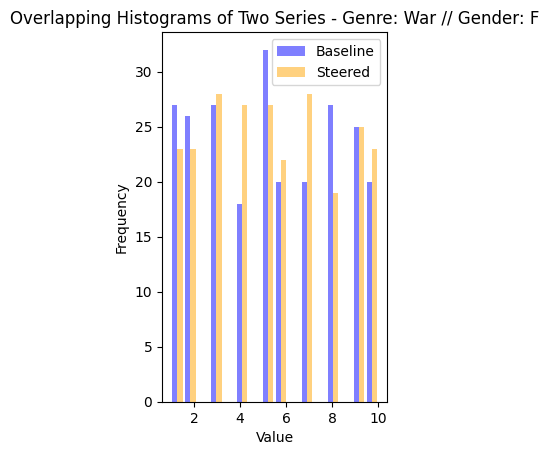

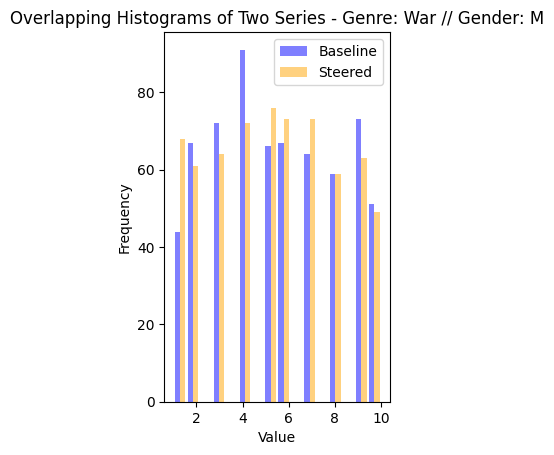

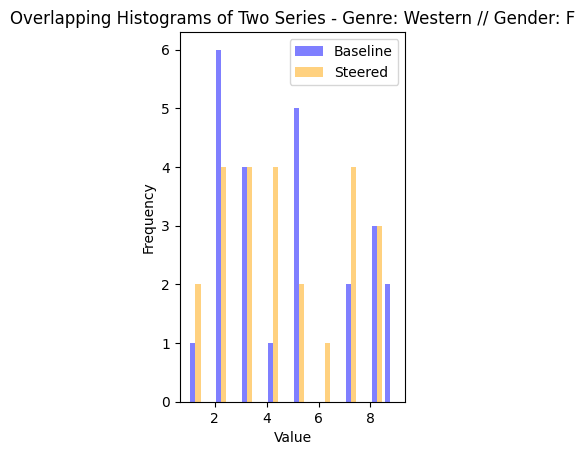

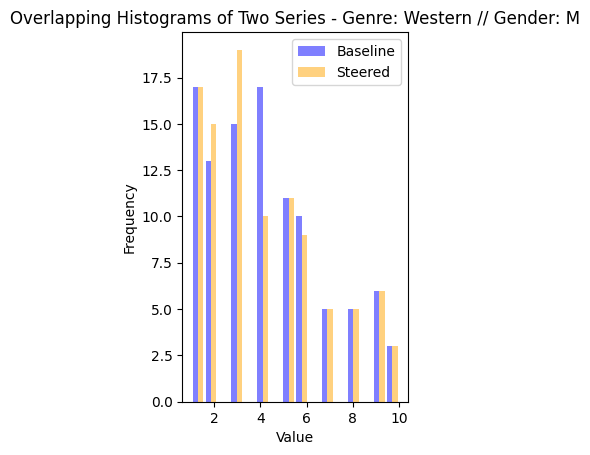

In [290]:
# after.shape
# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
for genre in genre_only_cols[1:]:
    # fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))
    aa = 1
    for user_gender in ('F','M'):
        data1 = df_empty[(df_empty['genre']==genre) & 
                        (df_empty['user_gender']==user_gender) & 
                        (df_empty['steer_type']=='baseline')]['row_num']
        data2 = df_empty[(df_empty['genre']==genre) & 
                        (df_empty['user_gender']==user_gender) & 
                        (df_empty['steer_type']=='steered')]['row_num']

        plt.subplot(1,2,aa)
        plt.hist([data1,data2],  bins=16, alpha=0.5, label=['Baseline','Steered'], color=['blue','orange']) #
        # plt.hist(data2,  bins=16, alpha=0.5, label='Steered', color='orange') #
        # Add labels and a title
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        plt.title(f"Overlapping Histograms of Two Series - Genre: {genre} // Gender: {user_gender}")
        plt.legend(loc='upper right') #

        # 4. Display the plot
        plt.show()
        aa = 2


130884.5 0.340615914514922


### Plot logits for MovieLens


In [380]:
from get_recs_ranker import GetRecs
folder = '/Users/jessicakahn/Documents/repos/Glocal_K/1/'
model_name = "llama3b"
if model_name == 'tinyllama':
    last_layer = 21
else:
    last_layer = 27

In [381]:
get_recs = GetRecs('movie', folder, model_name)
data_dict = get_recs.get_data_dict()

# Get a list of (key, value) pairs
items = list(data_dict.items())

np.random.seed(42)

# Randomly sample the desired number of users
if size_of_sample > len(data_dict):
    size_of_sample = len(data_dict)
new_dict = dict(random.sample(items, size_of_sample))
embedding_data_dict = get_recs.get_prompts_hidden(new_dict, gender_dict)
regress_list, results = get_recs.get_regress_list(embedding_data_dict)

/Users/jessicakahn/Documents/repos/steering/get_recs_ranker.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df_neg['item'] = rating_df_neg['item_id']#.map(self.movie_title_dict)
/Users/jessicakahn/Documents/repos/steering/get_recs_ranker.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df_pos['rating_count'] = rating_df_pos.groupby('user_id')['item_id'].transform('count')


Loading model:  meta-llama/Llama-3.2-3B-Instruct


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]
Some parameters are on the meta device because they were offloaded to the disk.


In [382]:
# results
W_probe = torch.tensor(regress_list[last_layer].coef_, dtype=torch.float32, device='cpu')
W_probe_T = W_probe.T
pinv_W_T = torch.linalg.pinv(W_probe).T

In [471]:
clf = regress_list[last_layer]
with open('scratch/probe_last_layer_for_plots.pkl','wb') as f:
    pickle.dump(clf,f)

In [470]:
torch.save(embedding_data_dict[last_layer],'scratch/embed_for_logits.pt')

In [486]:
clf.coef_

array([[ 0.20667899,  0.00525564,  0.06110221, ...,  0.15696333,
        -0.09824851,  0.13953805]], shape=(1, 3072))

In [488]:
# # Open the file and dump the data
# with open('scratch/movie_logit_plots.json', 'w') as json_file:
#     json.dump(embedding_data_dict[last_layer], json_file, indent=4)

embedding_data_dict[last_layer][0]['hidden'].shape

torch.Size([3072])

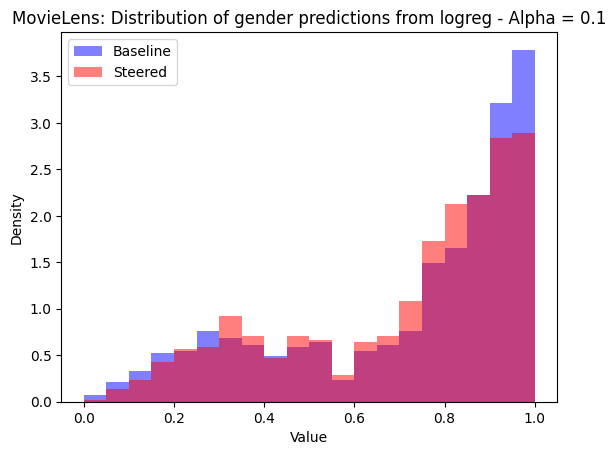

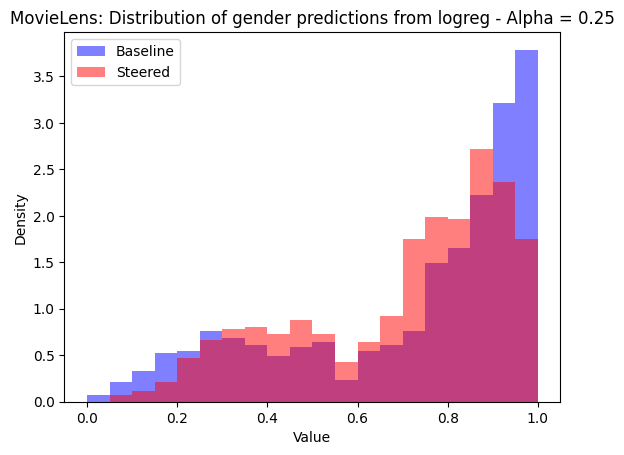

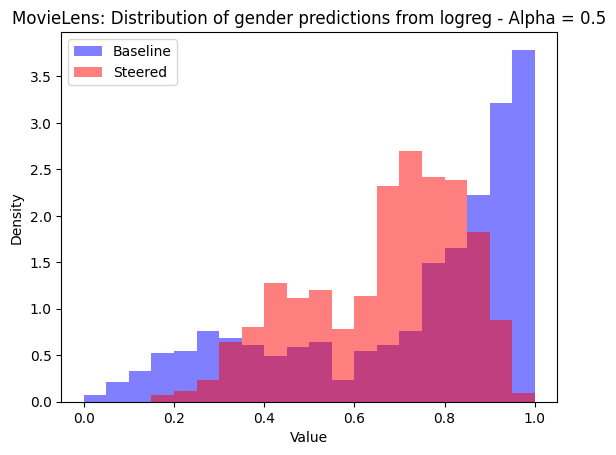

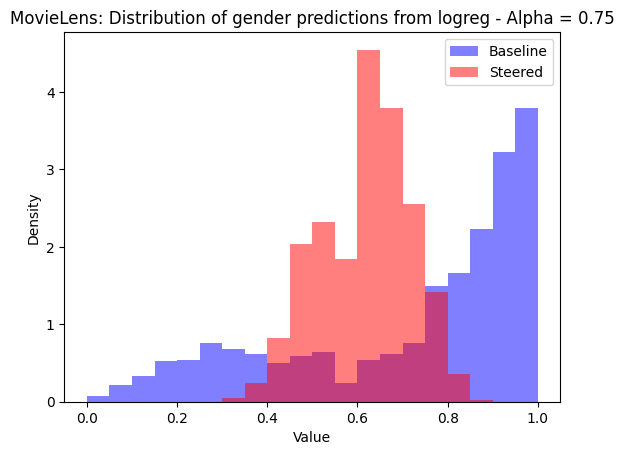

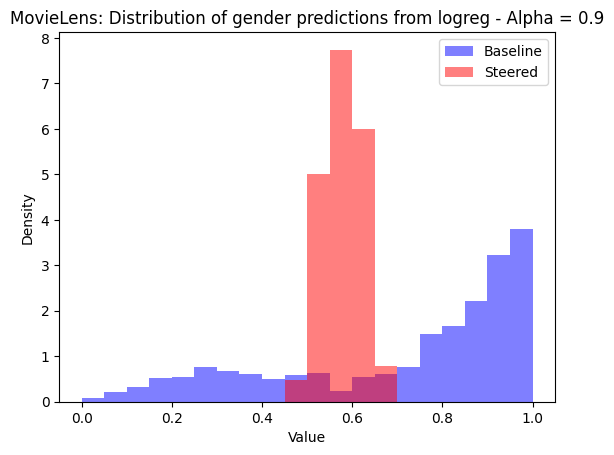

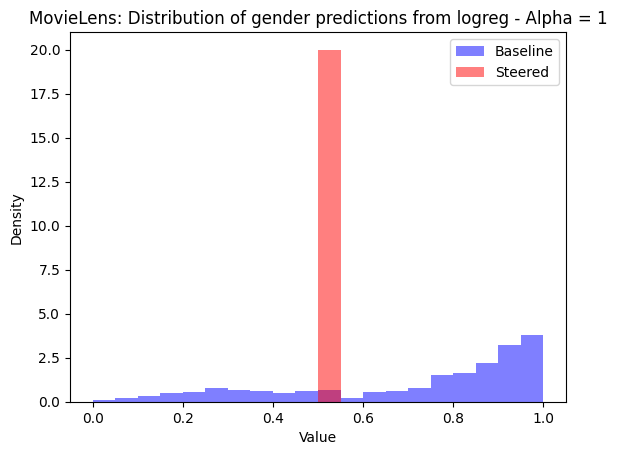

In [479]:
# embedding_data_dict[22]
# pred_list = 
for alpha in [0.1, 0.25, 0.5, 0.75, 0.9, 1]:
    plot_logits_M = dict(baseline=[], steered=[])
    plot_logits_F = dict(baseline=[], steered=[])
    for item in embedding_data_dict[last_layer]:
        x_proj0 = item['hidden'].to(torch.float32) @ W_probe_T
        x_proj = x_proj0 @ pinv_W_T
        # steering vector v (on GPU)
        v = -x_proj
        item['steered'] = item['hidden'] + alpha * v
        item['baseline_logit'] = clf.predict_proba(item['hidden'].reshape(1, -1).to(torch.float32))[0]
        item['steered_logit'] = clf.predict_proba(item['steered'].reshape(1, -1).to(torch.float32))[0]
        if user['demo'] == 'M':
            plot_logits_M['baseline'].append(user['baseline_logit'][1])
            plot_logits_M['steered'].append(user['steered_logit'][1])
        else:
            plot_logits_F['baseline'].append(user['baseline_logit'][1])
            plot_logits_F['steered'].append(user['steered_logit'][1])

    all_values = np.concatenate([plot_logits_F['baseline'], plot_logits_F['steered']])
    bins = np.histogram_bin_edges(all_values, bins=20)
    plt.hist([i['baseline_logit'][1] for i in embedding_data_dict[last_layer]], bins=bins, density=True, alpha=0.5, label='Baseline', color='blue')
    plt.hist([i['steered_logit'][1] for i in embedding_data_dict[last_layer]], bins=bins, density=True, alpha=0.5, label='Steered', color='red')

    # Add labels, title, and legend
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(f'MovieLens: Distribution of gender predictions from logreg - Alpha = {alpha}')
    plt.legend()

    # Display the plot
    plt.show()

    # Save the data for plotting
    # with open('scratch/movie_logit_plots_M.json', 'w') as json_file:
    #     json.dump(plot_logits_M, json_file, indent=4)

    # with open('scratch/movie_logit_plots_F.json', 'w') as json_file:
    #     json.dump(plot_logits_F, json_file, indent=4)




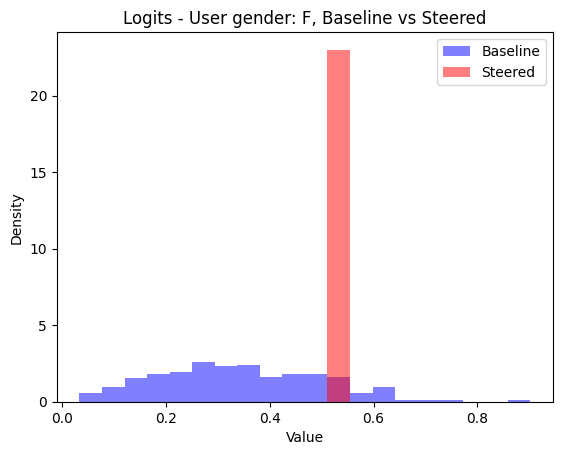

In [ ]:
# Plot both histograms with density=True


In [467]:
# plot_logits_M['steered']

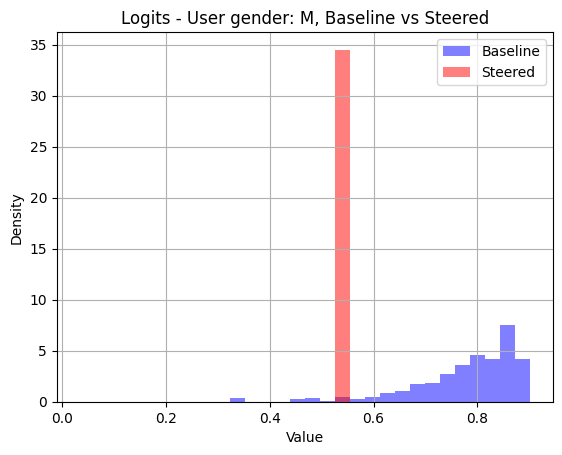

In [469]:
# Plot both histograms with density=True
plt.hist(plot_logits_M['baseline'], bins=bins, density=True, alpha=0.5, label='Baseline', color='blue')
plt.hist(plot_logits_M['steered'], bins=bins, density=True, alpha=0.5, label='Steered', color='red')

# Add labels, title, and legend
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Logits - User gender: M, Baseline vs Steered')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [565]:
logreg = LogisticRegression(max_iter=1000, solver='lbfgs')
c_param_elnet = 0.1
logreg_elastic = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    l1_ratio=0.5,  # 50% L1, 50% L2
    C=c_param_elnet,
    random_state=0
)

In [537]:
# Do the regression on a training set then plot on a test set
# len(embedding_data_dict[27])
from sklearn.model_selection import train_test_split

X = [j['hidden'].detach().cpu() for j in embedding_data_dict[27] if j['demo']!='Unknown']
X_tensor = torch.stack([
                    x.to(torch.float32)          # convert each element
                    .detach()
                    .cpu()
                    for x in X
                ])
X_np = X_tensor.numpy()
y = [j['demo'] for j in embedding_data_dict[27] if j['demo']!='Unknown']

# Make a test and train here
X_train, X_test, y_train, y_test = train_test_split(X_np, y, test_size=0.3, random_state=42)

In [527]:
logreg = logreg.fit(X_train, y_train)
# scores = cross_val_score(clf, X_np, y, cv=5, scoring='roc_auc')

In [566]:
logreg_elastic = logreg_elastic.fit(X_train, y_train)

/Users/jessicakahn/Documents/repos/steering/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [567]:
np.count_nonzero(logreg_elastic.coef_ > 0)

np.int64(3)

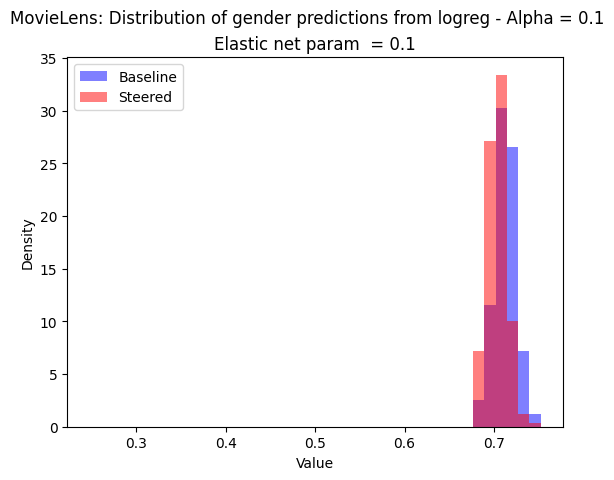

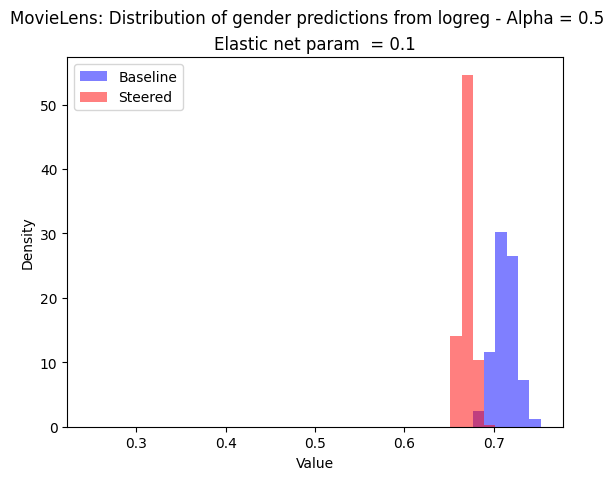

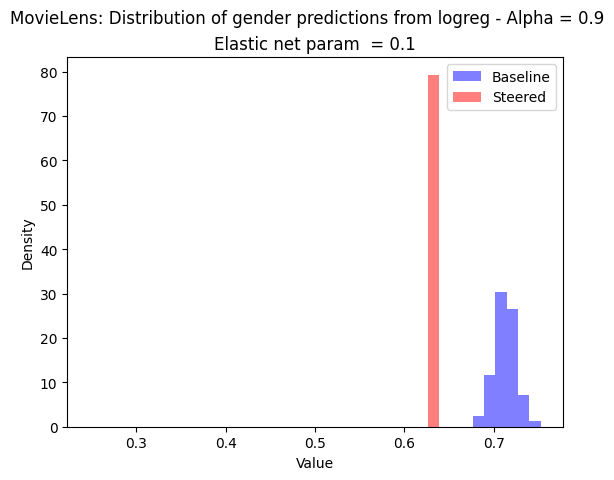

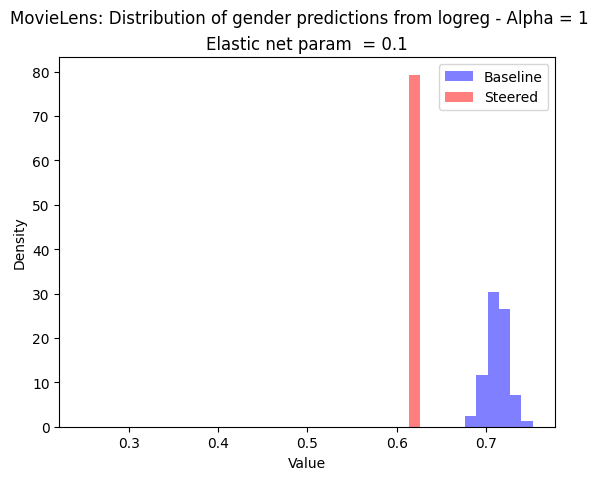

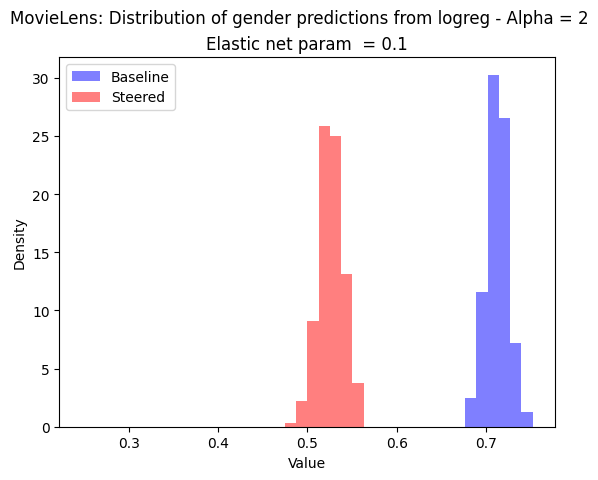

In [568]:
logreg_choice = logreg_elastic
W_probe = torch.tensor(logreg_choice.coef_, dtype=torch.float32, device='cpu')
W_probe_T = W_probe.T
pinv_W_T = torch.linalg.pinv(W_probe).T

X_test_pt = torch.from_numpy(X_test)
for alpha in [0.1, 0.5, 0.9, 1, 2]:
    test_dict = []
    for row in X_test_pt:
        item = {}
        x_proj0 = row @ W_probe_T
        x_proj = x_proj0 @ pinv_W_T
        # steering vector v (on GPU)
        v = -x_proj
        steered = row + alpha * v
        item['baseline_logit'] = logreg_choice.predict_proba(row.reshape(1, -1).to(torch.float32))[0]
        item['steered_logit'] = logreg_choice.predict_proba(steered.reshape(1, -1).to(torch.float32))[0]
        test_dict.append(item)
    
    all_values = np.concatenate([[x['baseline_logit'] for x in test_dict], [x['steered_logit'] for x in test_dict]])
    bins = np.histogram_bin_edges(all_values, bins=40)
    plt.hist([i['baseline_logit'][1] for i in test_dict], bins=bins, density=True, alpha=0.5, label='Baseline', color='blue')
    plt.hist([i['steered_logit'][1] for i in test_dict], bins=bins, density=True, alpha=0.5, label='Steered', color='red')
    # plt.xlim(0, 1)
    # Add labels, title, and legend
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.suptitle(f'MovieLens: Distribution of gender predictions from logreg - Alpha = {alpha}')
    plt.title(f'Elastic net param  = {c_param_elnet}')
    plt.legend()

    # Display the plot
    plt.show()

In [552]:
p = test_dict[0]['steered_logit'][1]

In [553]:
# test_dict
print(np.log((p)/(1-p)), logreg_elastic.intercept_)

0.20263174 [0.12514535]


In [554]:
# test_dict
from sklearn.metrics import roc_auc_score
y_probs = logreg_elastic.predict_proba(X_test)[:, 1]
auc_score_test = roc_auc_score(y_test, y_probs)
y_probs_train = logreg_elastic.predict_proba(X_train)[:, 1]
auc_score_train = roc_auc_score(y_train, y_probs_train)
# print('Evidence of overfitting')
print('AUC train: ', auc_score_train, 'AUC test: ', auc_score_test)

AUC train:  0.8326578858493752 AUC test:  0.6361887170014624


0.9960176742091635


#### Below here creates the DF with mapping required

In [149]:
item_type = 'book'

In [150]:
# your user-item pairs
pairs_to_predict = [(672,1131), (157,813), (157,931)]

In [151]:
# Score pairs
for user, item in pairs_to_predict:
    user_idx = u2i[user]
    item_idx = i2i[item]
    print(user_idx, item_idx)
    score = model.user_factors[user_idx].dot(model.item_factors[item_idx])
    print(f"Predicted score for user {user}, item {item}: {score:.3f}")

680 991
Predicted score for user 672, item 1131: -0.012
34 222
Predicted score for user 157, item 813: 0.248
34 415
Predicted score for user 157, item 931: 0.168


In [152]:
model.user_factors.shape, model.item_factors.shape

((943, 50), (1682, 50))

In [491]:
# u2i
# embedding_data_dict[last_layer][22].keys()

In [154]:
# Now run this on the full dataset
# df['input_candidate_cf_scores'] = 
for i, row in df.iterrows():
    cf_score_list = []
    user_idx = u2i[row.user_id]
    for j in row['input_candidate_ids']:
        if j:
            item_idx = i2i[j]
            cf_score_list.append(model.user_factors[user_idx].dot(model.item_factors[item_idx]))
        else:
            cf_score_list.append(None)
    # print(cf_score_list)
    row['input_candidate_cf_scores']=cf_score_list

In [155]:
# Map user index to 
df['user_idx']=df['user_id'].map(u2i)

In [156]:
# now run predictions
df['input_candidate_cf_scores'] = df.apply(
                lambda row: [
                    model.user_factors[row.user_idx].dot(model.item_factors[i2i[j]]) for j in row['input_candidate_ids']
                    if j in i2i
                    ],
                    axis=1
                )

In [157]:
df['baseline_cf_scores'] = df.apply(
                lambda row: [
                    model.user_factors[row.user_idx].dot(model.item_factors[i2i[j]]) for j in row['baseline_ids']
                    if j in i2i
                    ],
                    axis=1
                )

In [158]:
df['steered_cf_scores'] = df.apply(
                lambda row: [
                    model.user_factors[row.user_idx].dot(model.item_factors[i2i[j]]) for j in row['steered_ids']
                    if j in i2i
                    ],
                    axis=1
                )

In [159]:
movie_data = MovieData()
rating_df = movie_data.get_all_rating_df()

/Users/jessicakahn/Documents/repos/steering/data_classes.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df_pos['rating_count'] = rating_df_pos.groupby('user_id')['item_id'].transform('count')


In [160]:
rating_df.head(2)

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742


In [161]:
rating_df2 = (rating_df.groupby(['user_id'])
        .agg({'item_id': lambda x: x.tolist()})
        .reset_index())

In [162]:
# Append ratings to baseline and steered
# rating_df[rating_df.user_id==196]
inputs = [1131, 813, 220, 57, 931, 60, 493, 1642, 320, 1137]
rating_df[(rating_df.user_id == 672) & (rating_df.item_id.isin(inputs))]['rating'].values

array([1, 2])

In [163]:
for typ in ('baseline','steered'):
    df[f'{typ}_rating_from_hist'] = df.apply(
        lambda row: [
            rating_df.loc[
                (rating_df.user_id == row.user_id) &
                (rating_df.item_id == j),
                'rating'
            ].iloc[0]
            if not rating_df.loc[
                (rating_df.user_id == row.user_id) &
                (rating_df.item_id == j)
            ].empty
            else None
            for j in row[f'{typ}_ids']
            if j in row['input_candidate_ids']
        ],
        axis=1
    )

KeyboardInterrupt: 

In [ ]:
# Calculate average rank by rating (currently only for 2 negative items)
# TODO: include gender here to compare
bl_ranks = []
vf = [1,2]
for i, row in df[df.user_gender=='M'].iterrows():
    all_inds = [idx for idx, item in enumerate(row['baseline_rating_from_hist']) if item]
    bl_ranks.append(all_inds)
st_ranks = []
for i, row in df[df.user_gender=='M'].iterrows():
    all_inds = [idx for idx, item in enumerate(row['steered_rating_from_hist']) if item]
    st_ranks.append(all_inds)

print('Baseline: ', np.mean([i for sublist in bl_ranks for i in sublist]),
'Steered: ', np.mean([i for sublist in st_ranks for i in sublist]))

Baseline:  5.497615262321145 Steered:  5.452418096723869


#### Average rank where low-rated items appear broken out by user gender. 
Lower is worse. Amount changed is about the same for each gender. 

F: Baseline:  5.06 Steered:  5.02

M: Baseline:  5.49 Steered:  5.45

In [177]:
# item_df.head()
item_df['genre_sum'] = item_df.iloc[:, 1:20].sum(axis=1)

In [178]:
# item_df.head()
item_df['genre_sum'].value_counts()

genre_sum
1    833
2    569
3    215
4     51
5     11
6      3
Name: count, dtype: int64

In [ ]:
# df.columns
df[df.user_id==672]

,user_id,baseline_text,steered_text,input_candidates,input_candidates_list,input_candidate_ids,baseline_titles,baseline_ids,steered_titles,steered_ids,hist_titles,user_gender,user_idx,input_candidate_cf_scores,baseline_cf_scores,steered_cf_scores,movie_rating_from_hist,baseline_rating_from_hist,steered_rating_from_hist
0,672,"system\n\nCutting Knowledge Date: December 2023\nToday Date: 18 Dec 2025\n\nuser\n\nHi, I've watched and enjoyed the following movies:\n Grumpier Old Men (1995),Birdcage, The (1996),Career Girls (1997),In & Out (1997),Boot, Das (1981)Please rank the following movies in order from most to least likely to recommend to them to watch next. Only give the movie ranking with no other content or explanation.Safe (1995),Celluloid Closet, The (1995),Mirror Has Two Faces, The (1996),Priest (1994),Island of Dr. Moreau, The (1996),Three Colors: Blue (1993),Thin Man, The (1934),Some Mother's Son (1996),Paradise Lost: The Child Murders at Robin Hood Hills (1996),Beautiful Thing (1996)assistant\n\n1. Beautiful Thing (1996)\n2. Thin Man, The (1934)\n3. Paradise Lost: The Child Murders at Robin Hood Hills (1996)\n4. Some Mother's Son (1996)\n5. Celluloid Closet, The (1995)\n6. Island of Dr. Moreau, The (1996)\n7. Grumpier Old Men (1995)\n8. Mirror Has Two Faces, The (1996)\n9. Safe (1995)\n10. Priest (1994)\n11. Three Colors: Blue (1993)\n12. Birdcage, The (1996)\n13. Career Girls (1997)\n14. In & Out (1997)\n15. Boot,","system\n\nCutting Knowledge Date: December 2023\nToday Date: 18 Dec 2025\n\nuser\n\nHi, I've watched and enjoyed the following movies:\n Grumpier Old Men (1995),Birdcage, The (1996),Career Girls (1997),In & Out (1997),Boot, Das (1981)Please rank the following movies in order from most to least likely to recommend to them to watch next. Only give the movie ranking with no other content or explanation.Safe (1995),Celluloid Closet, The (1995),Mirror Has Two Faces, The (1996),Priest (1994),Island of Dr. Moreau, The (1996),Three Colors: Blue (1993),Thin Man, The (1934),Some Mother's Son (1996),Paradise Lost: The Child Murders at Robin Hood Hills (1996),Beautiful Thing (1996)assistant\n\n1. Beautiful Thing (1996)\n2. Some Mother's Son (1996)\n3. Paradise Lost: The Child Murders at Robin Hood Hills (1996)\n4. Celluloid Closet, The (1995)\n5. Grumpier Old Men (1995)\n6. Safe (1995)\n7. Thin Man, The (1934)\n8. Island of Dr. Moreau, The (1996)\n9. The Mirror Has Two Faces (1996)\n10. Priest (1994)\n11. Three Colors: Blue (1993)","Safe (1995),Celluloid Closet, The (1995),Mirror Has Two Faces, The (1996),Priest (1994),Island of Dr. Moreau, The (1996),Three Colors: Blue (1993),Thin Man, The (1934),Some Mother's Son (1996),Paradise Lost: The Child Murders at Robin Hood Hills (1996),Beautiful Thing (1996)","[Safe (1995), Celluloid Closet, The (1995), Mirror Has Two Faces, The (1996), Priest (1994), Island of Dr. Moreau, The (1996), Three Colors: Blue (1993), Thin Man, The (1934), Some Mother's Son (1996), Paradise Lost: The Child Murders at Robin Hood Hills (1996), Beautiful Thing (1996)]","[1131, 813, 220, 57, 931, 60, 493, 1642, 320, 1137]","[Beautiful Thing (1996), Thin Man, The (1934), Paradise Lost: The Child Murders at Robin Hood Hills (1996), Some Mother's Son (1996), Celluloid Closet, The (1995), Island of Dr. Moreau, The (1996), Grumpier Old Men (1995), Mirror Has Two Faces, The (1996), Safe (1995), Priest (1994), Three Colors: Blue (1993), Birdcage, The (1996), Career Girls (1997), In & Out (1997), Boot,]","[1137, 493, 320, 1642, 813, 931, 1028, 220, 1131, 57, 60, 25, 874, 301, None]","[Beautiful Thing (1996), Some Mother's Son (1996), Paradise Lost: The Child Murders at Robin Hood Hills (1996), Celluloid Closet, The (1995), Grumpier Old Men (1995), Safe (1995), Thin Man, The (1934), Island of Dr. Moreau, The (1996), The Mirror Has Two Faces (1996), Priest (1994), Three Colors: Blue (1993)]","[1137, 1642, 320, 813, 1028, 1131, 493, 931, 220, 57, 60]","[Grumpier Old Men, Birdcage, The, Career Girls, In & Out]",

In [ ]:
# df['baseline_rank'] = df['baseline_ids'].apply(lambda x: [])
bdf_long[(bdf_long['genre']=='Romance') & 
                (bdf_long['user_gender']=='F') & 
                (bdf_long['steer_type']=='baseline')]

,user_id,user_gender,row_num,movie_id,steer_type,genre,count


In [ ]:
# data2
from get_recs_ranker import MovieData
base_path = '/Users/jessicakahn/Documents/repos/'
folder = os.path.join(base_path,"Glocal_K/1/")
movie_data = MovieData(folder)
get_recs = movie_data.get_rating_df(rating_type='all',agg=True)

/Users/jessicakahn/Documents/repos/steering/get_recs_ranker.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import numpy as np


In [ ]:
# get_recs

In [ ]:
# Make bdf long so genres appear as variable "genre"



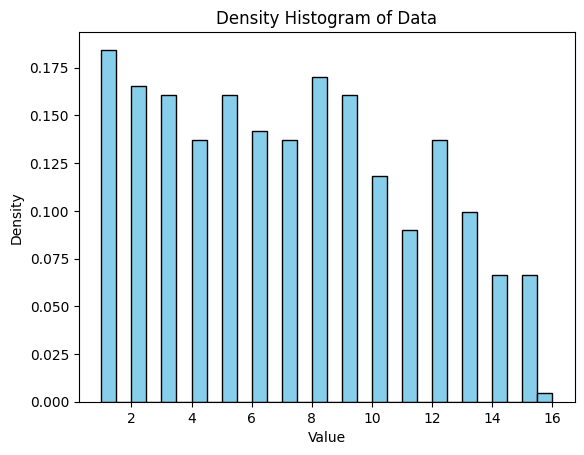

In [ ]:
# bdf_long[bdf_long.user_id==771]
# Plot the rank distribution by genre


In [ ]:
bl_gen_dict = {}
for gen in genre_only_cols:
    dict_list = []
    for s in ('F','M'):
        sub = bdf[(bdf[gen]==1) & (bdf['user_gender']==s)]
        dict_list.append(dict(user_gender= s, avg_rank = sub['row_num'].round(3).mean()))
    bl_gen_dict[gen] = dict_list

In [ ]:
st_gen_dict = {}
for gen in genre_only_cols:
    dict_list = []
    for s in ('F','M'):
        sub = sdf[(sdf[gen]==1) & (sdf['user_gender']==s)]
        dict_list.append(dict(user_gender= s, avg_rank = sub['row_num'].round(3).mean()))
    st_gen_dict[gen] = dict_list

In [ ]:
bl_gen_df = pd.DataFrame.from_dict(bl_gen_dict, orient='index')

In [ ]:

bl_gen_df2 = bl_gen_df.drop(0, axis=1).join(bl_gen_df[0].apply(pd.Series))
bl_gen_df2.columns = [1, 'user_genderF','avg_rankF']
bl_gen_df3 = bl_gen_df2.drop(1, axis=1).join(bl_gen_df2[1].apply(pd.Series))
bl_gen_df3.columns = ['user_genderF','avg_rankF','user_genderM','avg_rankM']
bl_gen_df3

In [ ]:
st_gen_df = pd.DataFrame.from_dict(st_gen_dict, orient='index')
st_gen_df2 = st_gen_df.drop(0, axis=1).join(st_gen_df[0].apply(pd.Series))
st_gen_df2.columns = [1, 'user_genderF','avg_rankF']
st_gen_df3 = st_gen_df2.drop(1, axis=1).join(st_gen_df2[1].apply(pd.Series))
st_gen_df3.columns = ['user_genderF','avg_rankF','user_genderM','avg_rankM']
st_gen_df3

,user_genderF,avg_rankF,user_genderM,avg_rankM
unknown,F,NaN,M,NaN
Action,F,7.500000,M,7.483333
Adventure,F,7.250000,M,6.600000
Animation,F,8.647059,M,8.184211
Children,F,10.333333,M,10.142857
Comedy,F,7.481481,M,7.361446
Crime,F,8.111111,M,6.304348
Documentary,F,7.750000,M,6.300000
Drama,F,6.685714,M,6.721519
Fantasy,F,NaN,M,11.500000


In [ ]:
# Plot baseline/steered rank distribution by genre

,user_genderF,avg_rankF,user_genderM,avg_rankM
unknown,F,NaN,M,NaN
Action,F,8.026217,M,8.116155
Adventure,F,7.787879,M,7.760753
Animation,F,8.811429,M,8.492958
Children,F,8.768116,M,8.559633
Comedy,F,7.715262,M,7.653922
Crime,F,6.566434,M,6.320955
Documentary,F,8.562500,M,7.815217
Drama,F,6.537862,M,6.515851
Fantasy,F,8.454545,M,8.800000


In [ ]:
# bdf.head()
for gen in genre_only_cols:
    print(gen, ' Baseline: ',bl_gen_dict[gen], '\n Steered: ', st_gen_dict[gen])

unknown  Baseline:  [{'user_gender': 'F', 'avg_rank': nan}, {'user_gender': 'M', 'avg_rank': nan}] 
 Steered:  [{'user_gender': 'F', 'avg_rank': nan}, {'user_gender': 'M', 'avg_rank': nan}]
Action  Baseline:  [{'user_gender': 'F', 'avg_rank': np.float64(8.02621722846442)}, {'user_gender': 'M', 'avg_rank': np.float64(8.116154873164218)}] 
 Steered:  [{'user_gender': 'F', 'avg_rank': np.float64(7.5)}, {'user_gender': 'M', 'avg_rank': np.float64(7.483333333333333)}]
Adventure  Baseline:  [{'user_gender': 'F', 'avg_rank': np.float64(7.787878787878788)}, {'user_gender': 'M', 'avg_rank': np.float64(7.760752688172043)}] 
 Steered:  [{'user_gender': 'F', 'avg_rank': np.float64(7.25)}, {'user_gender': 'M', 'avg_rank': np.float64(6.6)}]
Animation  Baseline:  [{'user_gender': 'F', 'avg_rank': np.float64(8.811428571428571)}, {'user_gender': 'M', 'avg_rank': np.float64(8.492957746478874)}] 
 Steered:  [{'user_gender': 'F', 'avg_rank': np.float64(8.647058823529411)}, {'user_gender': 'M', 'avg_rank':

In [ ]:
bdf_long = pd.melt(bdf, id_vars=['user_gender','row_num'], value_vars=[genre_only_cols],
                  var_name='Genre', value_name='Value')

TypeError: unhashable type: 'list'

In [ ]:
# bdf.row_num.unique()
bdf[genre_only_cols].shape, bdf['row_num'].shape

((6658, 19), (6658,))

In [ ]:
# Calculate genre * row_num? then compare for baseline vs steered by user gender
bdf[genre_only_cols] = bdf[genre_only_cols].mul(bdf['row_num'], axis=0)

In [ ]:
bdf.groupby('user_gender').sum()

,baseline_ids,user_id,row_num,movie_id,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
user_gender,,,,,,,,,,,,,,,,,,,,,,,
F,797618,935396,14386,797618.0,0.0,2143.0,1028.0,1542.0,605.0,3387.0,939.0,274.0,5871.0,93.0,505.0,349.0,519.0,1030.0,2518.0,916.0,3082.0,1888.0,35.0
M,1751968,2163574,34126,1751968.0,0.0,6079.0,2887.0,3618.0,933.0,7807.0,2383.0,719.0,14387.0,220.0,928.0,814.0,863.0,2034.0,5559.0,2874.0,7151.0,4724.0,267.0


In [ ]:
# Average row_num by genre baseline vs steered by user gender
bdf

In [ ]:
sdf = df[['steered_ids','user_id','user_gender']].explode('steered_ids')
sdf['row_num'] = sdf.groupby(['user_id','user_gender'], sort=False).cumcount() + 1
sdf = sdf.merge(item_df, how='left', left_on='steered_ids', right_on='movie_id')
sdf[genre_only_cols] = sdf[genre_only_cols].mul(bdf['row_num'], axis=0)

In [ ]:
bdf.head()
# .iloc[:,4:].head()
# baseline_genres

,baseline_ids,user_id,user_gender,movie_id,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1137,672,F,1137.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,493,672,F,493.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,320,672,F,320.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1642,672,F,1642.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,813,672,F,813.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
bdf.groupby('user_gender').agg({'user_id':'nunique'})

,user_id
user_gender,
F,147
M,353


In [ ]:
sdf.groupby('user_gender').agg({'user_id':'nunique'})

,user_id
user_gender,
F,147
M,353


In [ ]:
sdf.groupby('user_gender').sum()

,steered_ids,user_id,row_num,movie_id,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
user_gender,,,,,,,,,,,,,,,,,,,,,,,
F,805967,936384,14559,805967.0,0.0,1987.0,997.0,1219.0,514.0,3224.0,936.0,201.0,6545.0,64.0,453.0,431.0,467.0,1076.0,2588.0,864.0,3333.0,1897.0,78.0
M,1724434,2130066,33412,1724434.0,0.0,5291.0,2644.0,3047.0,824.0,7348.0,2819.0,612.0,16144.0,188.0,1014.0,625.0,803.0,2323.0,5545.0,2446.0,7405.0,4980.0,294.0


In [ ]:
# TODO: Try calculating Rank-Based Overlap metric (RBO)
from scipy import stats


In [176]:
# df[df.user_id==672]['input_candidates_list'][0]
# df.head()

/Users/jessicakahn/Documents/repos/steering/data_classes.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df_pos['rating_count'] = rating_df_pos.groupby('user_id')['item_id'].transform('count')


In [251]:
movie_title_dict = movie_data.get_title_dict()
reverse_title_dict = movie_data.get_reverse_title_dict()

In [ ]:
# text = movie_title_dict[1137]
# re.sub(r'\s*\(\d{4}\)\s*$', '', text)
for i in list(reverse_title_dict.keys()):
    if 'Shawshank' in i:
        print(i, reverse_title_dict[i])
# ['Shawshank Redemption']

Shawshank Redemption, The (1994) 64
Shawshank Redemption, The 64
The Shawshank Redemption (1994) 64
Shawshank Redemption (1994) 64
Shawshank Redemption 64
The Shawshank Redemption 64


In [ ]:
# ti_list = [movie_title_dict[64]]
id_list = [64, 1137]

In [ ]:
# Need to add all 6 combos of with and without date and the and year to the new_dict
new_dict = {}
for i in id_list:
    # Add the original to the lookup
    new_dict[movie_title_dict[i]] = i
    # 1. Strip year and add to dict
    title = re.sub(r'\s*\(\d{4}\)\s*$', '', movie_title_dict[i])
    new_dict[title] = i

    m = re.search(r'^(.*?),\s*(The|A|An)\s*(\(\d{4}\))$', movie_title_dict[i])
    if m:
        main, article, year = m.groups()
        new_dict[f"{article} {main} {year}"] = i
        new_dict[f"{main} {year}"] = i
        new_dict[f"{main}, {article}"] = i
        new_dict[f"{main}"] = i
        new_dict[f"{article} {main}"] = i



In [ ]:
new_dict

{'Shawshank Redemption, The (1994)': 64,
 'Shawshank Redemption, The': 64,
 'The Shawshank Redemption (1994)': 64,
 'Shawshank Redemption (1994)': 64,
 'Shawshank Redemption': 64,
 'The Shawshank Redemption': 64,
 'Beautiful Thing (1996)': 1137,
 'Beautiful Thing': 1137}

In [ ]:
# Create a title lookup without year 
# title_dict = {}
# for k, v in reverse_title_dict.items():
#     new_key = re.sub(r'\s*\((18[8-9]\d|19\d{2}|20[0-2]\d)\)\s*$', '', k)
#     other_key = re.sub(r',\s*The$', '', new_key)
#     title_dict[new_key] = v
#     title_dict[other_key] = v

In [ ]:
# title_dict
# title_dict['English Patient']
df.to_csv('output_data/movie/result_df.csv')

In [ ]:
df.head()

,user_id,baseline_text,steered_text,input_candidates,input_candidate_ids,baseline_titles,baseline_ids,steered_titles,steered_ids,hist_titles,user_gender
0,672,"system\n\nCutting Knowledge Date: December 2023\nToday Date: 18 Dec 2025\n\nuser\n\nHi, I've watched and enjoyed the following movies:\n Grumpier Old Men (1995),Birdcage, The (1996),Career Girls (1997),In & Out (1997),Boot, Das (1981)Please rank the following movies in order from most to least likely to recommend to them to watch next. Only give the movie ranking with no other content or explanation.Safe (1995),Celluloid Closet, The (1995),Mirror Has Two Faces, The (1996),Priest (1994),Island of Dr. Moreau, The (1996),Three Colors: Blue (1993),Thin Man, The (1934),Some Mother's Son (1996),Paradise Lost: The Child Murders at Robin Hood Hills (1996),Beautiful Thing (1996)assistant\n\n1. Beautiful Thing (1996)\n2. Thin Man, The (1934)\n3. Paradise Lost: The Child Murders at Robin Hood Hills (1996)\n4. Some Mother's Son (1996)\n5. Celluloid Closet, The (1995)\n6. Island of Dr. Moreau, The (1996)\n7. Grumpier Old Men (1995)\n8. Mirror Has Two Faces, The (1996)\n9. Safe (1995)\n10. Priest (1994)\n11. Three Colors: Blue (1993)\n12. Birdcage, The (1996)\n13. Career Girls (1997)\n14. In & Out (1997)\n15. Boot,","system\n\nCutting Knowledge Date: December 2023\nToday Date: 18 Dec 2025\n\nuser\n\nHi, I've watched and enjoyed the following movies:\n Grumpier Old Men (1995),Birdcage, The (1996),Career Girls (1997),In & Out (1997),Boot, Das (1981)Please rank the following movies in order from most to least likely to recommend to them to watch next. Only give the movie ranking with no other content or explanation.Safe (1995),Celluloid Closet, The (1995),Mirror Has Two Faces, The (1996),Priest (1994),Island of Dr. Moreau, The (1996),Three Colors: Blue (1993),Thin Man, The (1934),Some Mother's Son (1996),Paradise Lost: The Child Murders at Robin Hood Hills (1996),Beautiful Thing (1996)assistant\n\n1. Beautiful Thing (1996)\n2. Some Mother's Son (1996)\n3. Paradise Lost: The Child Murders at Robin Hood Hills (1996)\n4. Celluloid Closet, The (1995)\n5. Grumpier Old Men (1995)\n6. Safe (1995)\n7. Thin Man, The (1934)\n8. Island of Dr. Moreau, The (1996)\n9. The Mirror Has Two Faces (1996)\n10. Priest (1994)\n11. Three Colors: Blue (1993)","Safe (1995),Celluloid Closet, The (1995),Mirror Has Two Faces, The (1996),Priest (1994),Island of Dr. Moreau, The (1996),Three Colors: Blue (1993),Thin Man, The (1934),Some Mother's Son (1996),Paradise Lost: The Child Murders at Robin Hood Hills (1996),Beautiful Thing (1996)","[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 656, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, ...]","[Beautiful Thing (1996), Thin Man, The (1934), Paradise Lost: The Child Murders at Robin Hood Hills (1996), Some Mother's Son (1996), Celluloid Closet, The (1995), Island of Dr. Moreau, The (1996), Grumpier Old Men (1995), Mirror Has Two Faces, The (1996), Safe (1995), Priest (1994), Three Colors: Blue (1993), Birdcage, The (1996), Career Girls (1997), In & Out (1997), Boot,]","[1137, 493, 320, 1642, 813, 931, 1028, 220, 1131, 57, 60, 25, 874, 301, None]","[Beautiful Thing (1996), Some Mother's Son (1996), Paradise Lost: The Child Murders at Robin Hood Hills (1996), Celluloid Closet, The (1995), Grumpier Old Men (1995), Safe (1995), Thin Man, The (1934), Island of Dr. Moreau, The (1996), The Mirror Has Two Faces (1996), Priest (1994), Three Colors: Blue (1993)]","[1137, 1642, 320, 813, 

In [ ]:
# x = df[df.user_id==157]['baseline_text']
text = x.str.split(llm_recs.str3).str[1].str.split('assistant\\n').str[0]
# .apply(lambda x:re.findall(r'\d*\.\s*(.*?)\s*\(\d{4}\)', x))

In [ ]:
text

1    Jean de Florette (1986),Bridge on the River Kwai, The (1957),Great Escape, The (1963),Close Shave, A (1995),Paradise Lost: The Child Murders at Robin Hood Hills (1996),Schindler's List (1993),Wallace & Gromit: The Best of Aardman Animation (1996),Twister (1996),Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963),Saint, The (1997)
Name: baseline_text, dtype: object